In [2]:
from pystac_client import Client
import satsearch
import os
import boto3
import rasterio as rio
from pyproj import Transformer
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import pandas as pd
#import geopandas as gpd
from fiona.crs import from_epsg
import numpy as np
from scipy import ndimage
from rasterio.plot import plotting_extent
import rioxarray
from rasterio.crs import CRS
import xml.etree.ElementTree as ET
import urllib.request
from rasterio.plot import plotting_extent
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

In [3]:
#Definicion de la geometria
lat, lon = -35.24, -70.57
bbox = [lon-1, lat+1, lon+1, lat-1]
coords = dict(type="Point", coordinates=(lon, lat))

#Definicion de fechas en formato AAAA-MM-DD
timeRange = '2018-09-01/2019-05-01'

In [4]:
#Busqueda con cobertura nubosa 10 %
#LANDSAT 
collection = "landsat-c2l1"
LandsatSTAC = Client.open("https://landsatlook.usgs.gov/stac-server", headers=[])
Landsat= LandsatSTAC.search ( 
    intersects = coords,
    datetime = timeRange,
    query={"eo:cloud_cover": {"lt": 10},"platform":{"gt":'LANDSAT_7'}},
    collections = collection
    )

Landsat_items = [i.to_dict() for i in Landsat.get_items()]

#################
#Lista de fechas
#################
fechas_Landsat=[]
for item in Landsat.get_items():
    fechas_Landsat.append(item.datetime)
    #print(item.properties)


#Elimino las fechas repetidas
# Use the keep parameter to consider only the first instance of a duplicate row to be unique
# Creating a DataFrame object
df = pd.DataFrame(fechas_Landsat)
fechas_dt=pd.to_datetime(df[0])
date=fechas_dt.dt.date
bool_series = date.duplicated(keep='first')



Landsat_fechas=[d for (d, remove) in zip(fechas_Landsat, bool_series) if not remove]
Landsat_items=[d for (d, remove) in zip(Landsat_items, bool_series) if not remove]

print(f"{len(Landsat_items)} escenas Landsat 8 encontradas")

16 escenas Landsat 8 encontradas


In [5]:
#Descarga de metadato Landsat. 

url = "https://ers.cr.usgs.gov/login"

op=webdriver.ChromeOptions()

op.add_argument('--no-sandbox')
op.add_argument('--verbose')
op.add_argument("--disable-notifications")

op.add_experimental_option("prefs", {
  "download.default_directory": r"C\Users\dolor\Downloads",
  "download.prompt_for_download": False,
  "download.directory_upgrade": True,
  "safebrowsing.enabled": True, 
  "helperApps.neverAsk.saveToDisk": "text/xml", 
  "helperApps.neverAsk.openFile": "text/xml"})


op.add_argument('--disable-gpu')
op.add_argument('--disable-software-rasterizer')

driver = webdriver.Chrome(options=op)
driver.get(url)

u = driver.find_element("name", "username")
u.send_keys('dolorescorva')
p = driver.find_element("name",'password')
p.send_keys('CONAE19591544')
p.send_keys(Keys.RETURN)


#Acceso a los xml de las imganes Landsat 
L_items = Landsat.get_all_items()
for item in L_items:
    assets = item.assets  
    url=assets['MTL.xml'].href
    driver.get(url)

driver.quit()

In [4]:
def recorte(geotiff_file):
    with rio.Env(aws_session):
        with rio.open(geotiff_file) as geo_fp:
            # Definir los extremos del recorte  
            x_top, y_top = geo_fp.index( 355000, 6100000)
            x_bottom, y_bottom = geo_fp.index( 359000, 6097000 )
            # Crear una ventana con rasterio
            window = rio.windows.Window.from_slices( ( x_top, x_bottom ), ( y_top, y_bottom ) )                
            # Guardar el dato
            subset = geo_fp.read(1, window=window)
    return subset

def re_proj(geotiff_file):
    with rio.Env(aws_session):
        with rioxarray.open_rasterio(geotiff_file).squeeze() as geo_fp:
           #Generamos el sistema de referencia final
            crs_out = CRS.from_string('EPSG:32719')
            # Reproyectamos
            geo_fp_rp = geo_fp.rio.reproject(crs_out)
            #RECORTE
            geometries = [
                {
                    'type': 'Polygon',
                    'coordinates': [[
                        [355000, 6097000],
                        [355000, 6100000],
                        [359000, 6100000],
                        [359000, 6097000 ],
                        [355000, 6097000 ]
                    ]]
                }
            ]
            clipped = geo_fp_rp.rio.clip(geometries)
            
    return clipped

def guardar_GTiff(fn,crs,transform,mat, nodata = 0):
        if len(mat.shape)==2:
            count=1
        else:
            count=mat.shape[0]
        with rasterio.open(
        fn,
        'w',
        driver='GTiff',
        height=mat.shape[-2],
        width=mat.shape[-1],
        count=count,
        dtype=np.float32,
        nodata = nodata,
        crs=crs,
        transform=transform) as dst:
            if len(mat.shape)==2:
                dst.write(mat.astype(np.float32), 1)
            else:
                for b in range(0,count):
                    dst.write(mat[b].astype(np.float32), b+1)

def sunglint(item):
    ##################################
    # Estimación de Sunglint
    ##################################

    #Los angulos están en cientos de grados,
    #hay que dividir por 100 y pasar a radianes. 
    #El angulo de vision es un promedio para los sensores en las diferentes bandas. 

    aws_session = rio.session.AWSSession(boto3.Session(), requester_pays=True)
    #Angulo de visión acimutal
    VAA=item['assets']['VAA']['alternate']['s3']['href']
    #Angulo de visión zenital
    VZA=item['assets']['VZA']['alternate']['s3']['href']
    #Angulo solar acimutal
    SAA=item['assets']['SAA']['alternate']['s3']['href']
    #Angulo zolar zenital
    SZA=item['assets']['SZA']['alternate']['s3']['href']

    Ang_VA=re_proj(VAA)
    Ang_VZ=re_proj(VZA)
    Ang_SA=re_proj(SAA)
    Ang_SZ=re_proj(SZA)
    
    Ang_VA=np.deg2rad(Ang_VA/100)
    Ang_VZ=np.deg2rad(Ang_VZ/100)
    Ang_SA=np.deg2rad(Ang_SA/100)
    Ang_SZ=np.deg2rad(Ang_SZ/100)
   
    #Calculo del angulo de glint
    phi = Ang_SA-Ang_VA
    cos_glint_ang = np.cos(Ang_VZ) * np.cos(Ang_SZ) - np.sin(Ang_VZ) * np.sin(Ang_SZ) * np.cos(phi)

    #conversion de los resultados en grados, 
    glint_array = np.degrees(np.arccos(cos_glint_ang))
    
    return glint_array

In [5]:
######################################################################
#Obtencion de indices espectrales para todas las imagenes disponibles.
#Landsat
######################################################################
aws_session = rio.session.AWSSession(boto3.Session(), requester_pays=True)

NHIs_list_Land=[]
NHIn_list_Land=[]
sunglint_list=[]    
Fechas_L_list=[]
for i,item in enumerate(Landsat_items):
    
    print('Abriendo la imagen', item['id'])
    
    ###################################
    #Identificacion de bandas saturadas
    ###################################
    f = open('../XML/'+item['id']+'_MTL.xml')
    tree =  ET.parse(f)
    root =  tree.getroot()
    f.close()
    
    atributes=root.find('IMAGE_ATTRIBUTES')
    saturation=[]
    
    for j in range(9):
        saturation.append(atributes[j+15].text)
    
    try:
        index=saturation.index('Y')

        if 'Y' in saturation: 
            if index==5:
                print('La banda NIR está saturada. Se calcula solo el índice de NHIs')
                ################################
                #Estimación del angulo de glint
                ################################
                glint_ang=sunglint(item)
                sunglint_list.append(glint_ang)

                #Bandas para el calculo de los índices
                swir1=item['assets']['swir16']['alternate']['s3']['href']
                swir2=item['assets']['swir22']['alternate']['s3']['href']
                #nir=item['assets']['nir08']['alternate']['s3']['href']
                asset_hrefs=[swir1,swir2]
                img=[re_proj(href) for href in asset_hrefs]

                ############
                #CORRECCION
                ###########
                f = open('../XML/'+item['id']+'_MTL.xml')
                tree =  ET.parse(f)
                root =  tree.getroot()
                f.close()

                radiometric_data = root.find('LEVEL1_RADIOMETRIC_RESCALING')
                mult=[]
                add=[]

                for k in range(11):
                    mult.append(radiometric_data[k].text)
                    add.append(radiometric_data[k+11].text)

                img[0]=img[0]*float(mult[5])+float(add[5])
                img[1]=img[1]*float(mult[6])+float(add[6])


                ##########################    
                #Calculo de NHIs y NHIN,
                #indices espectrales
                ##########################
                NHIs=(img[1]-img[0])/(img[1]+img[0])
                NHIs_list_Land.append(NHIs)

                NHIn=np.ones(NHIs.shape)*(-1)
                NHIn_list_Land.append(NHIn)
                
                Fechas_L_list.append(Landsat_fechas[i])
   
                           
            elif index==6:
                print('La banda SWIR1 está saturada. La imagen es descartada')
                
                
            elif index==7:
                print('La banda SWIR2 está saturada. Se calcula solo el índice de NHIn')
                ################################
                #Estimación del angulo de glint
                ################################
                glint_ang=sunglint(item)
                sunglint_list.append(glint_ang)

                #Bandas para el calculo de los índices
                swir1=item['assets']['swir16']['alternate']['s3']['href']
                nir=item['assets']['nir08']['alternate']['s3']['href']
                asset_hrefs=[nir,swir1]
                img=[re_proj(href) for href in asset_hrefs]

                ############
                #CORRECCION
                ###########
                f = open('../XML/'+item['id']+'_MTL.xml')
                tree =  ET.parse(f)
                root =  tree.getroot()
                f.close()

                radiometric_data = root.find('LEVEL1_RADIOMETRIC_RESCALING')
                mult=[]
                add=[]

                for k in range(11):
                    mult.append(radiometric_data[k].text)
                    add.append(radiometric_data[k+11].text)

                img[0]=img[0]*float(mult[4])+float(add[4])
                img[1]=img[1]*float(mult[5])+float(add[5])
                

                ##########################    
                #Calculo de NHIs y NHIN,
                #indices espectrales
                ##########################
             

                NHIn=(img[1]-img[0])/(img[1]+img[0])
                NHIn_list_Land.append(NHIn)
                NHIs=np.ones(NHIn.shape)*(-1)
                NHIs_list_Land.append(NHIs) 
                
                Fechas_L_list.append(Landsat_fechas[i])
                
            else: 
                print('Las bandas a utilizar no están saturadas')
    
                ################################
                #Estimación del angulo de glint
                ################################
                glint_ang=sunglint(item)
                sunglint_list.append(glint_ang)

                #Bandas para el calculo de los índices
                swir1=item['assets']['swir16']['alternate']['s3']['href']
                swir2=item['assets']['swir22']['alternate']['s3']['href']
                nir=item['assets']['nir08']['alternate']['s3']['href']
                asset_hrefs=[nir,swir1,swir2]
                img=[re_proj(href) for href in asset_hrefs]


                ############
                #CORRECCION
                ###########
                f = open('../XML/'+item['id']+'_MTL.xml')
                tree =  ET.parse(f)
                root =  tree.getroot()
                f.close()

                radiometric_data = root.find('LEVEL1_RADIOMETRIC_RESCALING')
                mult=[]
                add=[]

                for k in range(11):
                    mult.append(radiometric_data[k].text)
                    add.append(radiometric_data[k+11].text)

                img[0]=img[0]*float(mult[4])+float(add[4])
                img[1]=img[1]*float(mult[5])+float(add[5])
                img[2]=img[2]*float(mult[6])+float(add[6])


                ##########################    
                #Calculo de NHIs y NHIN,
                #indices espectrales
                ##########################
                NHIs=(img[2]-img[1])/(img[2]+img[1])
                NHIs_list_Land.append(NHIs)

                NHIn=(img[1]-img[0])/(img[1]+img[0])
                NHIn_list_Land.append(NHIn)
                
                Fechas_L_list.append(Landsat_fechas[i])
            
            
    except ValueError:
        print('Las bandas a utilizar no están saturadas')
    
        ################################
        #Estimación del angulo de glint
        ################################
        glint_ang=sunglint(item)
        sunglint_list.append(glint_ang)
        
        #Bandas para el calculo de los índices
        swir1=item['assets']['swir16']['alternate']['s3']['href']
        swir2=item['assets']['swir22']['alternate']['s3']['href']
        nir=item['assets']['nir08']['alternate']['s3']['href']
        asset_hrefs=[nir,swir1,swir2]
        img=[re_proj(href) for href in asset_hrefs]

      
        ############
        #CORRECCION
        ###########
        f = open('../XML/'+item['id']+'_MTL.xml')
        tree =  ET.parse(f)
        root =  tree.getroot()
        f.close()

        radiometric_data = root.find('LEVEL1_RADIOMETRIC_RESCALING')
        mult=[]
        add=[]

        for k in range(11):
            mult.append(radiometric_data[k].text)
            add.append(radiometric_data[k+11].text)

        img[0]=img[0]*float(mult[4])+float(add[4])
        img[1]=img[1]*float(mult[5])+float(add[5])
        img[2]=img[2]*float(mult[6])+float(add[6])


        ##########################    
        #Calculo de NHIs y NHIN,
        #indices espectrales
        ##########################
        NHIs=(img[2]-img[1])/(img[2]+img[1])
        NHIs_list_Land.append(NHIs)

        NHIn=(img[1]-img[0])/(img[1]+img[0])
        NHIn_list_Land.append(NHIn)
        
        Fechas_L_list.append(Landsat_fechas[i])


Abriendo la imagen LC08_L1TP_232085_20190422_20200829_02_T1
La banda SWIR1 está saturada. La imagen es descartada
Abriendo la imagen LC08_L1TP_232085_20190406_20200829_02_T1
La banda NIR está saturada. Se calcula solo el índice de NHIs
Abriendo la imagen LC08_L1TP_232085_20190321_20200829_02_T1
La banda SWIR1 está saturada. La imagen es descartada
Abriendo la imagen LC08_L1TP_233084_20190312_20200829_02_T1
La banda SWIR1 está saturada. La imagen es descartada
Abriendo la imagen LC08_L1TP_233084_20190224_20200829_02_T1
La banda SWIR1 está saturada. La imagen es descartada
Abriendo la imagen LC08_L1TP_232085_20190217_20200829_02_T1
La banda SWIR1 está saturada. La imagen es descartada
Abriendo la imagen LC08_L1TP_232085_20190201_20200829_02_T1
La banda NIR está saturada. Se calcula solo el índice de NHIs
Abriendo la imagen LC08_L1TP_233084_20190123_20200829_02_T1
La banda NIR está saturada. Se calcula solo el índice de NHIs
Abriendo la imagen LC08_L1TP_232085_20190116_20200830_02_T1
La b

In [29]:
#Stack 8 bandas
del NHIn_list_Land[8]
del NHIs_list_Land[8]
del sunglint_list[8]
del Fechas_L_list[8]
NHIn_stack_Land=np.stack(NHIn_list_Land)
NHIs_stack_Land=np.stack(NHIs_list_Land)
sunglint_stack=np.stack(sunglint_list)

In [79]:
#Analisis de Sunglint para pixeles anomalos
#Se toman los valores de sunglint para la posicion de los pixeles anomalos y se evalúa si cumple la condicion: 
# Og<2º
#En estos casos el pixel es descartado como anomalo por efecto de sunglint. 

for i in range(len(Fechas_L_list)): 
    NHIn=NHIn_stack_Land[i]
    NHIs=NHIs_stack_Land[i]
    select_1=np.where(NHIn >= 0,1,0)
    select_2=np.where(NHIs >= 0,1,0)
    sun_NHIn=sunglint_stack[i]*select_1
    sun_NHIs=sunglint_stack[i]*select_2
    
    sun_NHIn_f=np.where((sun_NHIn<2) & (sun_NHIn>0) , 1, 0)
    sun_NHIs_f=np.where((sun_NHIs<2) & (sun_NHIs>0), 1, 0)
    
    Tot_sun_NHIn=np.count_nonzero(sun_NHIn_f == 1)
    Tot_sun_NHIs=np.count_nonzero(sun_NHIs_f == 1)
 
    if Tot_sun_NHIn>0: 
        print('Para la fecha', Fechas_L_list[i] )
        print('Hay',Tot_sun_NHIn, 'píxeles para NHIn que son descartados por muy bajo ángulo de sunglint')
    if Tot_sun_NHIs>0: 
        print('Para la fecha', Fechas_L_list[i] )
        print('Hay',Tot_sun_NHIs, 'píxeles para NHIs que son descartados por muy bajo ángulo de sunglint')

In [50]:
#Generacion de la estidistica para Sentinel
#data Frame con índice como la fecha
df_1 = pd.DataFrame(index=Fechas_L_list)
df_1['max'] = 0.0
df_1['min'] = 0.0
df_1['mean'] = 0.0
df_1['std'] = 0.0

for i, fecha in enumerate(Fechas_L_list):
    data_NHIs = NHIs_stack_Land[i]
    df_1.loc[fecha,'max'] = data_NHIs.max()
    df_1.loc[fecha,'min'] = data_NHIs.min()
    df_1.loc[fecha,'mean'] = data_NHIs.mean()
    df_1.loc[fecha,'std'] = data_NHIs.std()

0 2019-04-06
1 2019-02-01
2 2019-01-23
3 2019-01-16
4 2018-12-15
5 2018-11-20
6 2018-11-04
7 2018-10-12
8 2018-09-10


In [50]:
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange

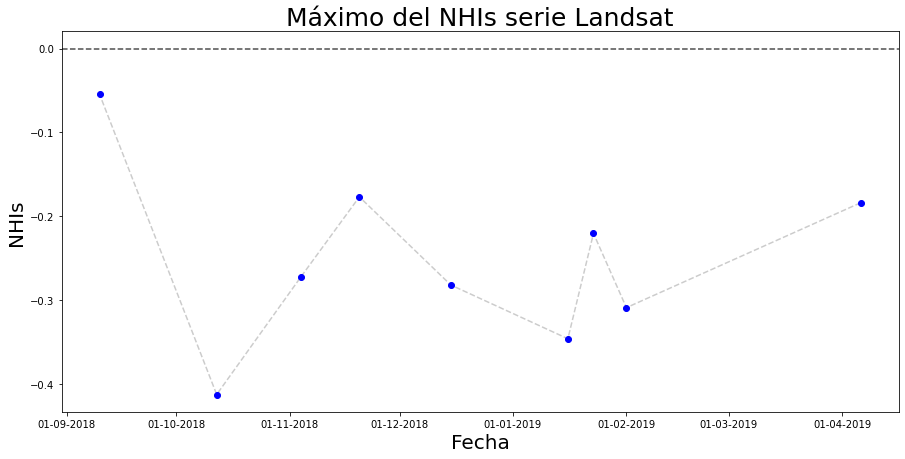

In [98]:
#Grafico de la media con devío estandar
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
plt.title('Máximo del NHIs serie Landsat', fontsize=25)
plt.xlabel('Fecha', fontsize=20)
plt.ylabel('NHIs', fontsize=20)

max_clase = df_1['max'].values
ax.plot(Fechas_L_list,max_clase,color='0.8', linestyle='--')
ax.plot(Fechas_L_list,max_clase,'bo' )
ax.axhline(0, linestyle='--', color='0.3') #Linea limite para el índice

import matplotlib.dates as mdates

myFmt = mdates.DateFormatter('%d-%m-%Y') # here you can format your datetick labels as desired
plt.gca().xaxis.set_major_formatter(myFmt)

In [84]:
#Generacion de la estidistica para Landsat
#data Frame con índice como la fecha

df_2 = pd.DataFrame(index=Fechas_L_list)
df_2['max'] = 0.0
df_2['min'] = 0.0
df_2['mean'] = 0.0
df_2['std'] = 0.0

for i, fecha in enumerate(Fechas_L_list):
    data_NHIn = NHIn_stack_Land[i]
    df_2.loc[fecha,'max'] = data_NHIn.max()
    df_2.loc[fecha,'min'] = data_NHIn.min()
    df_2.loc[fecha,'mean'] = data_NHIn.mean()
    df_2.loc[fecha,'std'] = data_NHIn.std()

0 2019-04-06
1 2019-02-01
2 2019-01-23
3 2019-01-16
4 2018-12-15
5 2018-11-20
6 2018-11-04
7 2018-10-12
8 2018-09-10


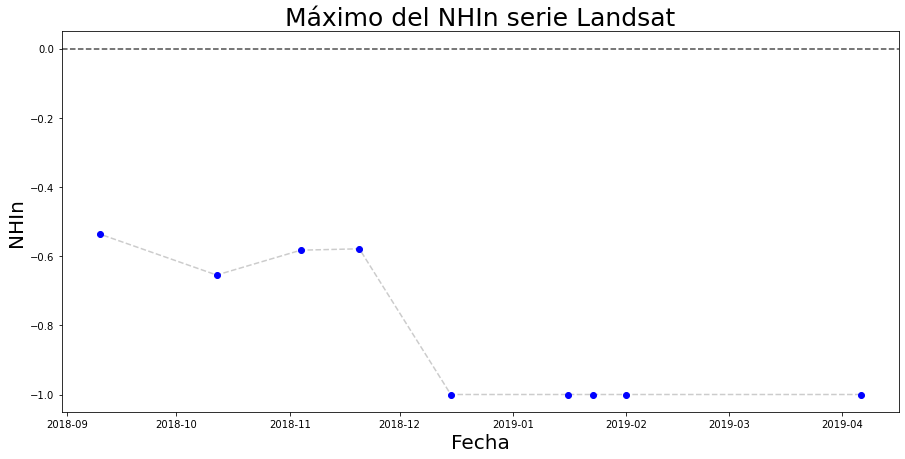

In [85]:
#Grafico de los valores máximos
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
plt.title('Máximo del NHIn serie Landsat', fontsize=25)
plt.xlabel('Fecha', fontsize=20)
plt.ylabel('NHIn', fontsize=20)

max_clase = df_2['max'].values
ax.plot(Fechas_L_list,max_clase,color='0.8', linestyle='--')
ax.plot(Fechas_L_list,max_clase,'bo' )
ax.axhline(0, linestyle='--', color='0.3') #Linea limite para el índice


IndexError: index 6 is out of bounds for axis 0 with size 6

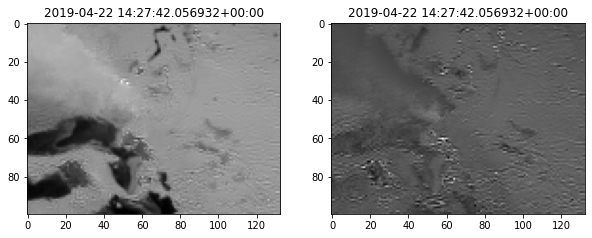

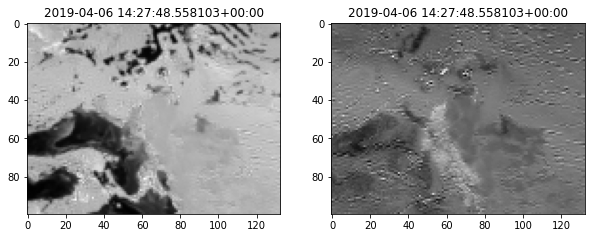

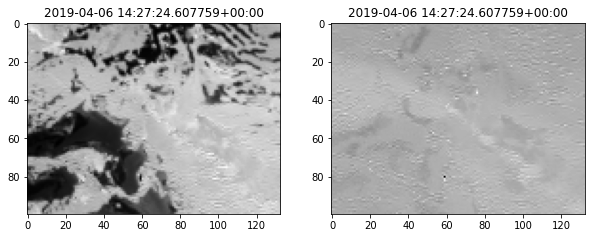

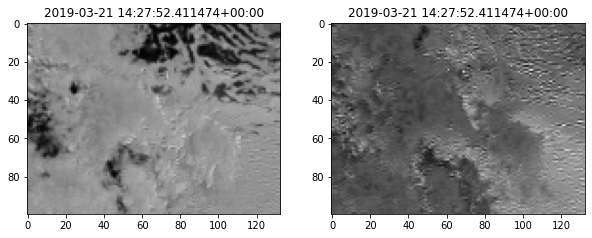

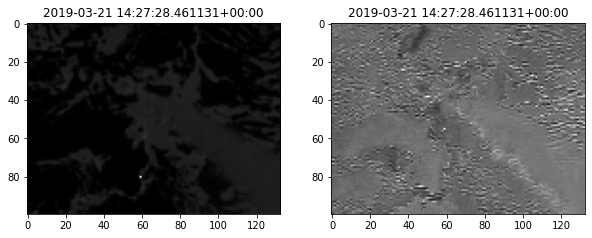

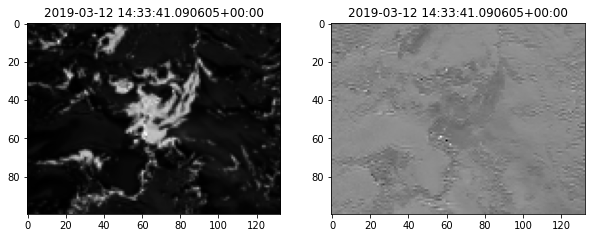

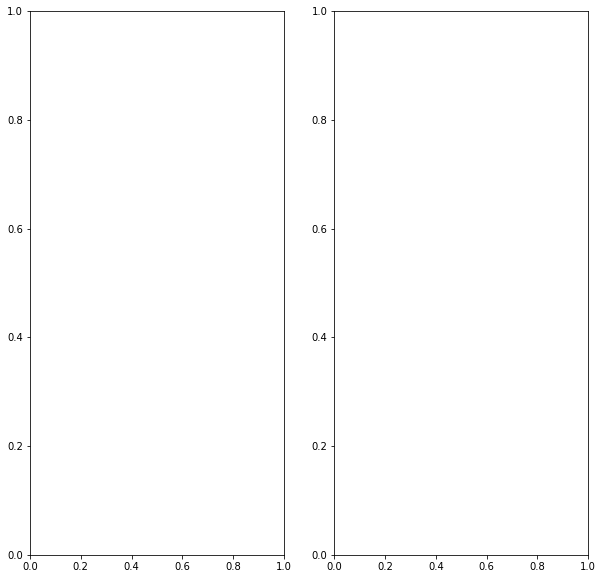

In [9]:
plot_extent=(355000,359000,6097000, 6100000)
major_xticks = np.arange(355000,359000, 1000)
major_yticks = np.arange(6097000, 6100000, 1000)

for i in range(len(fechas_Landsat)):
# Cree un nuevo subgrafo, la cuadrícula es 1x2, el número de serie es 1, el primer número es el número de filas, el segundo número es el número de columnas, lo que indica la disposición de los subgrafos, y el tercer número es el número de serie del subgrafo
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
        
    scalebar = AnchoredSizeBar(ax[0].transData,
                           1000, '1 km', 'lower right', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=1)
    
    ax[0].imshow(NHIn_stack_Land[i],cmap='gray',extent=plot_extent)

    ax[0].set_title(fechas_Landsat[i])
    ax[0].set_xticks(major_xticks)
    ax[0].set_yticks(major_yticks)
    ax[0].add_artist(scalebar)
    ax[0].grid(which='major', alpha=0.5)

    ax[1].imshow(NHIs_stack_Land[i],cmap='gray', extent=plot_extent)

    ax[1].set_title(fechas_Landsat[i])
    ax[1].set_xticks(major_xticks)
    ax[1].set_yticks(major_yticks)
    ax[1].add_artist(scalebar)
    ax[1].grid(which='major', alpha=0.5)
